# Analyse modelled fluxes

- Should also compare results of gridded NEE predictions (correlations etc.) with EC point data to see if they follow the same trends. 

In [1]:
import sys
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from datacube.utils.dask import start_local_dask

In [2]:
client = start_local_dask(mem_safety_margin='2Gb')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32833,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:35573,Total threads: 16
Dashboard: /proxy/38391/status,Memory: 44.92 GiB
Nanny: tcp://127.0.0.1:33193,


In [5]:
var = 'GPP'
results_name = 'GPP_2003_2021.nc'
data_path = '/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/prediction_data_2003_2021.nc'

## Open predictor data

In [6]:
data = xr.open_dataset(data_path)

## Open predictions

In [7]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name,
                       chunks=dict(x=250,y=250, time=-1)).sel(time=slice('2003','2018'))

## Linear trends

In [8]:
# import xarray as xr
import dask.array as da
from dask.delayed import delayed
from  scipy import stats

def _calc_slope(y):
    """return linear regression statistical variables"""
    mask = np.isfinite(y)
    x = np.arange(len(y))
    return stats.linregress(x[mask], y[mask])

# regression function defition
def regression(y):
    """apply linear regression function along time axis"""
    axis_num = y.get_axis_num('time')
    return da.apply_along_axis(_calc_slope, axis_num, y)

# fill pixels that are all-NaNs
allnans = ds.isnull().all('time').compute()
ds = ds.where(~allnans, other=0)

# regression analysis
delayed_objs = delayed(regression)(ds).persist()

# transforms dask.delayed to dask.array
results = da.from_delayed(delayed_objs, shape=(5, ds.shape[1:][0], ds.shape[1:][1]), dtype=np.float32)
results = results.compute()
results = results.compute() #need this twice haven't figured out why

# statistical variables definition
variables = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']

# coordination definition
coords = {'y': ds.y, 'x': ds.x}

# output xarray.Dataset definition
ds_out = xr.Dataset(
    data_vars=dict(slope=(["y", "x"], results[0]),
                   intercept=(["y", "x"], results[1]),
                   r_value=(["y", "x"], results[2]),
                   p_value=(["y", "x"], results[3]),
                   std_err=(["y", "x"], results[4]),
                  ),
    coords = coords)

#remask all-NaN pixel
ds_out = ds_out.where(~allnans)
ds_out

/apps/python3/3.9.2/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/apps/python3/3.9.2/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/apps/python3/3.9.2/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


<xarray.Dataset>
Dimensions:      (y: 681, x: 841)
Coordinates:
    spatial_ref  int32 4236
  * y            (y) float32 -10.0 -10.05 -10.1 -10.15 ... -43.9 -43.95 -44.0
  * x            (x) float32 112.0 112.1 112.1 112.2 ... 153.9 153.9 153.9 154.0
Data variables:
    slope        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    intercept    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    r_value      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    p_value      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    std_err      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

### Mask with Evergreen Trees

In [9]:
lc = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/Landcover_merged_5km.nc').isel(time=1)
lc['latitude'] = lc.latitude.astype('float32')
lc['longitude'] = lc.longitude.astype('float32')
lc = lc.rename({'latitude':'y','longitude':'x'})

trees = lc.PFT == 10

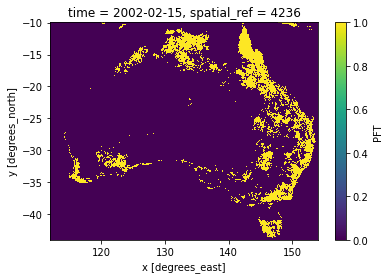

In [11]:
trees.plot.imshow()

In [21]:
ds_out.slope.max()

<xarray.DataArray 'slope' ()>
array(0.6169302)
Coordinates:
    spatial_ref  int32 4236

In [49]:
# import folium
# import odc.geo
# import folium
# from odc.geo.xr import assign_crs

# # Create folium Map (ipyleaflet is also supported)
# m = folium.Map(tiles='openstreetmap')

# # Plot each sample image with different colormap
# ds_out.slope.where(trees).odc.add_to(m, cmap='BrBG', vmax=0.2,vmin=-0.2, opacity=1.0)

# # Zoom map to Australia
# m.fit_bounds(ds_out.odc.map_bounds())

# # tile = folium.TileLayer(
# #         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
# #         attr = 'Esri',
# #         name = 'Esri Satellite',
# #         overlay = True,
# #         control = True
# #        ).add_to(m)

# folium.LayerControl().add_to(m)
# display(m)


# ds_out.slope.where(trees).plot.imshow(size=10, robust=True, cmap='BrBG')
# plt.title('Linear Trend in Evergreen Forest GPP 2003-2018');

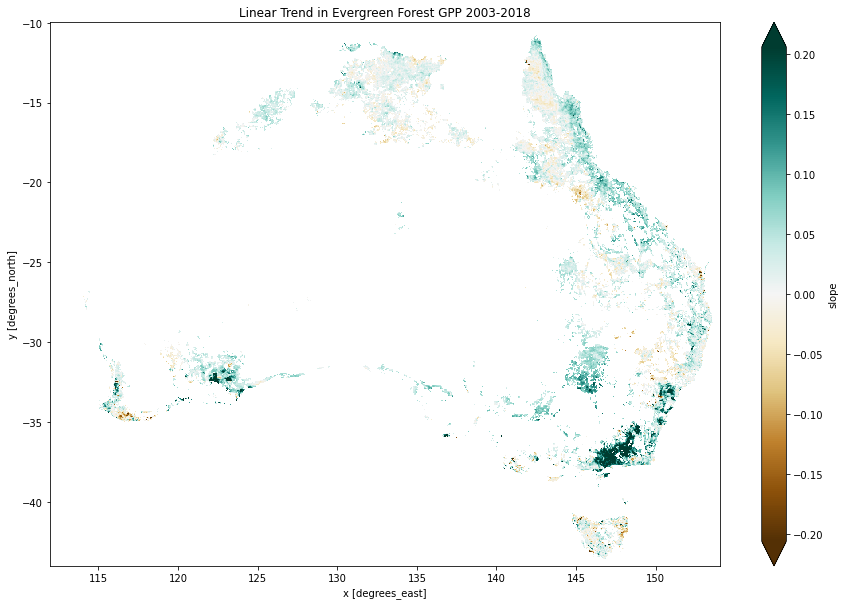

In [30]:
ds_out.slope.where(trees).plot.imshow(size=10, robust=True, cmap='BrBG')
plt.title('Linear Trend in Evergreen Forest GPP 2003-2018');

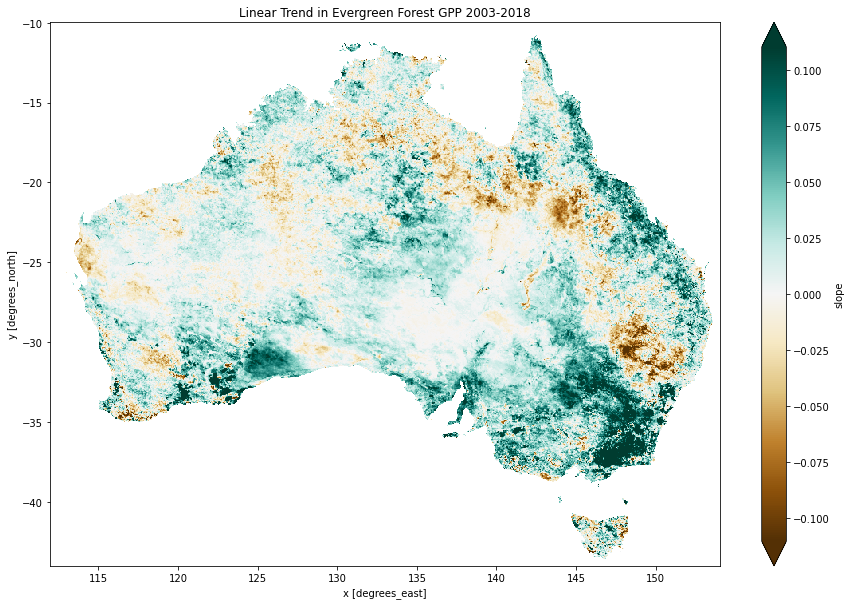

In [12]:
ds_out.slope.plot.imshow(size=10, robust=True, cmap='BrBG')
plt.title('Linear Trend in Evergreen Forest GPP 2003-2018');

# Correlations

TODO: compute p-values and plot hashes over areas with significance > 0.05
https://xskillscore.readthedocs.io/en/stable/api/xskillscore.pearson_r_eff_p_value.html

In [35]:
data = data.sel(time=ds.time) #match times

In [47]:
precip_corr = xr.corr(ds, data['precip'], dim='time').compute()
vpd_corr = xr.corr(ds, data['VPD'], dim='time').compute()
dT_corr = xr.corr(ds, data['LST-Tair'], dim='time').compute()
tavg_corr = xr.corr(ds, data['Ta'], dim='time').compute()

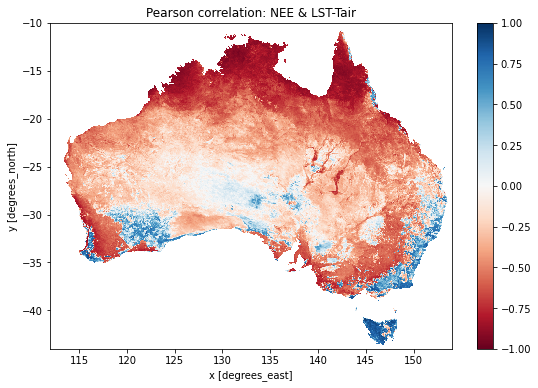

In [46]:
dT_corr.plot.imshow(size=6, vmin=-1, vmax=1, cmap='RdBu')
plt.title('Pearson correlation: NEE & LST-Tair');

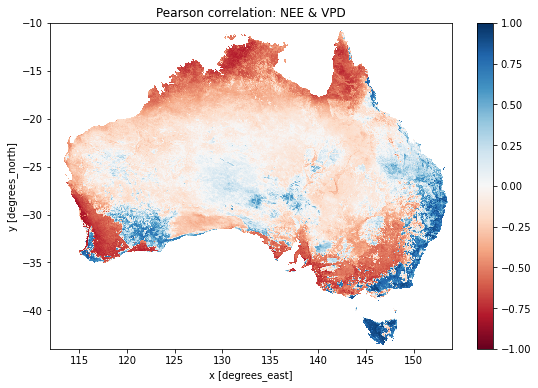

In [48]:
vpd_corr.plot.imshow(size=6, vmin=-1, vmax=1, cmap='RdBu')
plt.title('Pearson correlation: NEE & VPD');

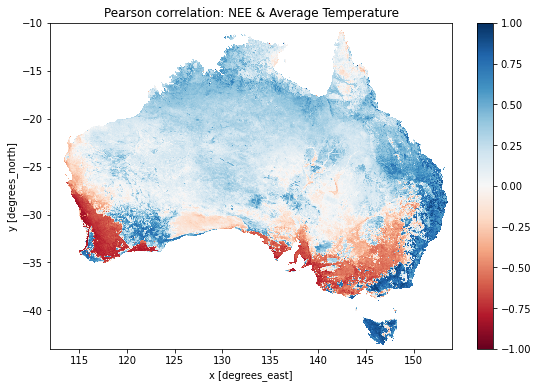

In [42]:
tavg_corr.plot.imshow(size=6, vmin=-1, vmax=1, cmap='RdBu')
plt.title('Pearson correlation: NEE & Average Temperature');

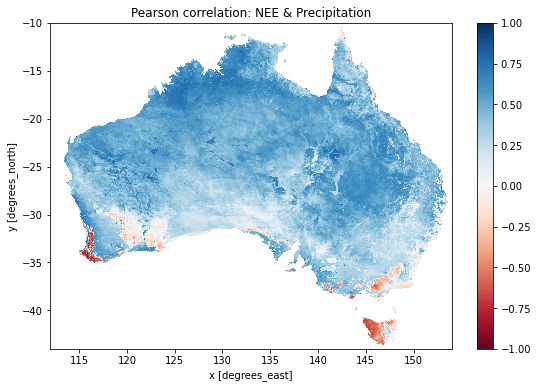

In [43]:
precip_corr.plot.imshow(size=6, vmin=-1, vmax=1, cmap='RdBu')
plt.title('Pearson correlation: NEE & Precipitation');

## Plot relationships between NEE, GPP, ER and environmental variables (P, T, SM etc)

Following Lui et al. (2018) 

## Causality

###  Granger casaulity tests?

### Bayesian structure learning?
https://towardsdatascience.com/a-step-by-step-guide-in-detecting-causal-relationships-using-bayesian-structure-learning-in-python-c20c6b31cee5

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, maxlag=12, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(ndvi, variables = ndvi.columns)  